# Загрузка Pandas и очистка данных

In [99]:
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import re

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок


In [100]:
df = pd.read_csv('main_task_new.csv')

In [101]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки


### Number of Reviews
Нужно заполнить пропуски

<AxesSubplot:>

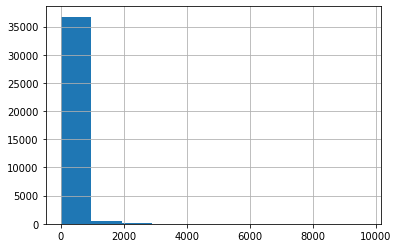

In [102]:
'''Посмотрим, как распределены величины.'''
df['Number of Reviews'].hist()

Судя по характеру данных, я бы сказала, что лучше брать median, чем mean.

In [103]:
'''Заполняем пропуски в Number of Reviews медианными по столбцу значениями.'''

df['Number of Reviews'].fillna(df['Number of Reviews'].median(), inplace=True)

### Reviews

In [104]:
'''Создадим столбец со списком дат отзывов на ресторан в формате datetime.'''

review_dates = []

for item in df['Reviews']:
    review_dates.append(re.findall(r"\d\d/\d\d/\d\d\d\d", item))

for i, dates in enumerate(review_dates):

    if len(dates) == 1:
        review_dates[i][0] = datetime.strptime(dates[0], '%m/%d/%Y')
    
    if len(dates) > 1:
        for j, date in enumerate(dates):
            review_dates[i][j] = datetime.strptime(date, '%m/%d/%Y')
        
df['Review_dates'] = review_dates
del review_dates

In [105]:
'''Создадим столбец с датами последнего отзыва и посмотрим, какой был самый последний.'''


def last_date(dlist):
    '''Возвращает последнюю из указанных в списке дат отзывов или None, если список пустой.'''
    if len(dlist) == 0:
        return None
    
    if len(dlist) == 0:
        return dlist[0]
    
    last = dlist[0]
    for date in dlist:
        if date > last:
            last = date
    return last


df['Last_Review_Date'] = df.Review_dates.apply(last_date)

print('Дата последнего написанного отзыва: ', df.Last_Review_Date.max())

Дата последнего написанного отзыва:  2018-02-26 00:00:00


In [106]:
'''Заполним пропуски медианным по столбцу значением.'''

df['Last_Review_Date'].fillna(df.Last_Review_Date.median(), inplace=True)

In [107]:
'''Добавим столбец - количество дней с последнего отзыва.'''

def ddate(rdate):
    '''Возвращает разницу в днях между now и датой последнего отзыва.'''
    return (datetime.now()-rdate).days


df['Date_Delta'] = df['Last_Review_Date'].apply(ddate)
df['Date_Delta']

0        1299
1        1477
2        1291
3        1395
4        1342
         ... 
39995    1314
39996    1309
39997    1722
39998    1472
39999    1999
Name: Date_Delta, Length: 40000, dtype: int64

<AxesSubplot:>

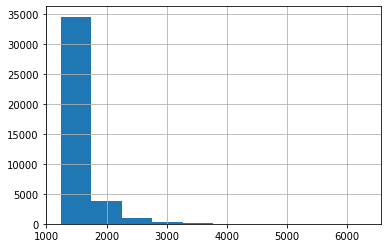

In [108]:
'''Посмотрим, как распределяются даты последних отзывов (опосредованно через разницу с сейчас).'''

df['Date_Delta'].hist()

Судя по характеру данных, заполнять пропуски в последних датах медианными значениями было неплохим решением.

In [109]:
'''Посчитаем наибольшую разницу между датами отзывов на ресторан. 
Запишем такие разницы в датах в отдельный стоблец. 
Если отзывов меньше двух, то присвоим значение = 0.'''


def max_date_diff(dlist):
    if len(dlist) < 2:
        return 0
    first = dlist[0]
    last = dlist[0]
    for date in dlist:
        if first > date:
            first = date
        if last < date:
            last = date
    return (last - first).days


df['Max_Review_Date_Diff'] = df.Review_dates.apply(max_date_diff)

print('Максимальная величина разницы между датами отзывов: ', df.Max_Review_Date_Diff.max())

Максимальная величина разницы между датами отзывов:  3207


### Price Range

In [110]:
'''Посмотрим, какие значения есть в Price Range и заполним пропуски нулями.'''

print(df['Price Range'].unique())
df['Price Range'].fillna(0, inplace = True)
print(df['Price Range'].unique())

['$$ - $$$' nan '$$$$' '$']
['$$ - $$$' 0 '$$$$' '$']


In [111]:
'''Переведем Price Range в числовое значение 0 - нет; 1 - $; 2 - $$-$$$; 3 - $$$$. 
Запишем это в новый столбец.'''

def price_in_num(item):
    
    if item == 0:
        return 0
    if item == '$':
        return 1
    if item == '$$ - $$$':
        return 2
    if item == '$$$$':
        return 2

df['Price_Num'] = df['Price Range'].apply(price_in_num)

### City

In [112]:
len(df['City'].unique())

31

In [116]:
'''Посмотрим, сколько ресторанов в городах.'''

cities = df['City'].unique().tolist() # Список городов, по которому будем создавать признаки.
all_cities = df['City'].tolist() # Список всех упоминаний городов, чтобы определить их популярность.
print(Counter(all_cities).most_common())

[('London', 5757), ('Paris', 4897), ('Madrid', 3108), ('Barcelona', 2734), ('Berlin', 2155), ('Milan', 2133), ('Rome', 2078), ('Prague', 1443), ('Lisbon', 1300), ('Vienna', 1166), ('Amsterdam', 1086), ('Brussels', 1060), ('Hamburg', 949), ('Munich', 893), ('Lyon', 892), ('Stockholm', 820), ('Budapest', 816), ('Warsaw', 727), ('Dublin', 673), ('Copenhagen', 659), ('Athens', 628), ('Edinburgh', 596), ('Zurich', 538), ('Oporto', 513), ('Geneva', 481), ('Krakow', 443), ('Oslo', 385), ('Helsinki', 376), ('Bratislava', 301), ('Luxembourg', 210), ('Ljubljana', 183)]


Думаю, поскольку городов всего 31, а минимальное значение ресторанов в городах - 183, то можно и для всех городов создать dummy variables.

In [115]:
'''Циклом по списку cities создаем признаки.'''

def ifcity(city, column):
    '''Возвращает 1, если город из ячейки с данными (city) совпадает с городом из списка,
    по которому создается колонка (column). И 0, если не совпадает.'''
    if city == column:
        return 1
    return 0


for item in cities:
    df[item] = df['City'].apply(ifcity, args=(item,))
    #print(item)

### Cuisine Style

In [117]:
'''Преобразуем списк кухонь из str в list. Добавим столбец с количеством кухонь в каждом ресторане.'''

df['Cuisine Style'] = df['Cuisine Style'].fillna("['Unknown']")
df['Cuisine Style'] = df['Cuisine Style'].str.replace('[','')
df['Cuisine Style'] = df['Cuisine Style'].str.replace(']','')
df['Cuisine Style'] = df['Cuisine Style'].str.replace("'","")

cuisines_set = set() # здесь будет список уникальных названий cuisine style
cuisines_list = [] # здесь будет список всех упоминаний всех cuisine style, чтобы посмотреть на их популярность
cuisines_lists = [] # здесь будет список списков кухонь для каждого ресторана

for item in df['Cuisine Style']:
    result = item.split(r", ")
    cuisines_lists.append(result)
    for cuisine in result:
        cuisines_set.add(cuisine)
        cuisines_list.append(cuisine)

df['Cuisine Style'] = cuisines_lists # Меняем str значение списка на list
df['Cuisine_Num'] = [len(a) for a in cuisines_lists] # Количество кухонь в ресторане

del cuisines_lists

<ipython-input-117-f14702f08289>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Cuisine Style'] = df['Cuisine Style'].str.replace('[','')
<ipython-input-117-f14702f08289>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Cuisine Style'] = df['Cuisine Style'].str.replace(']','')


In [73]:
'''Количество всех кухонь, самая популярная кухня, среднее число кухонь в ресторане.'''
cuisines_set = set()
cuisines_list = []

for list in df['Cuisine Style']:
    for cuisine in list:
        cuisines_set.add(cuisine)
        cuisines_list.append(cuisine)
cuisines_set = cuisines_set - {'Unknown'}
#cuisines_list = list(filter(('Unknown').__ne__, cuisines_list))
#cuisines_list = filter(lambda a: a != 'Unknown', cuisines_list)

print('Всего кухонь: ', len(cuisines_set))
print('Самая популярная кухня: ', Counter(cuisines_list).most_common()[0])
print('Среднее число кухонь в ресторане: ', df.Cuisine_Num.mean())

Всего кухонь:  125
Самая популярная кухня:  ('Vegetarian Friendly', 11189)
Среднее число кухонь в ресторане:  2.6224


In [74]:
'''Какие 10 кухонь самые популярные?'''

most_common_cuisines = []

dict_cuisines = dict(Counter(cuisines_list).most_common()[:11])
del dict_cuisines['Unknown']

for a in dict_cuisines.keys():
    most_common_cuisines.append(a)
    print(a)

del dict_cuisines

Vegetarian Friendly
European
Mediterranean
Italian
Vegan Options
Gluten Free Options
Bar
French
Asian
Pizza


In [75]:
'''Создадим dumpy variables по видам 10 самых популярных значений cuisine style.'''

def ifcuisine(clist, cuisine):
    if cuisine in clist:
        return 1
    return 0

for item in most_common_cuisines:
    df[item] = df['Cuisine Style'].apply(ifcuisine, args=(item,))
    print(item)

Vegetarian Friendly
European
Mediterranean
Italian
Vegan Options
Gluten Free Options
Bar
French
Asian
Pizza


In [76]:
'''Посмотрим, что получилось.'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Restaurant_id         40000 non-null  object        
 1   City                  40000 non-null  object        
 2   Cuisine Style         40000 non-null  object        
 3   Ranking               40000 non-null  float64       
 4   Rating                40000 non-null  float64       
 5   Price Range           40000 non-null  object        
 6   Number of Reviews     40000 non-null  float64       
 7   Reviews               40000 non-null  object        
 8   URL_TA                40000 non-null  object        
 9   ID_TA                 40000 non-null  object        
 10  Review_dates          40000 non-null  object        
 11  Last_Review_Date      40000 non-null  datetime64[ns]
 12  Date_Delta            40000 non-null  int64         
 13  Max_Review_Date_

In [77]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA',
       'Review_dates', 'Last_Review_Date', 'Date_Delta',
       'Max_Review_Date_Diff', 'Price_Num', 'Paris', 'Stockholm', 'London',
       'Berlin', 'Munich', 'Oporto', 'Milan', 'Bratislava', 'Vienna', 'Rome',
       'Barcelona', 'Madrid', 'Dublin', 'Brussels', 'Zurich', 'Warsaw',
       'Budapest', 'Copenhagen', 'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon',
       'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana',
       'Athens', 'Luxembourg', 'Krakow', 'Cuisine_Num', 'Vegetarian Friendly',
       'European', 'Mediterranean', 'Italian', 'Vegan Options',
       'Gluten Free Options', 'Bar', 'French', 'Asian', 'Pizza'],
      dtype='object')

#### Удалить столбцы не float и не int

In [78]:
'''1 вариант: удаление object столбцов без функции drop (с сохранением 'Restaurant_id')'''

df = df.select_dtypes(exclude=['object']).assign(Restaurant_id=df['Restaurant_id'].values)

In [79]:
'''2 вариант: удаление object столбцов с функцией drop (с сохранением 'Restaurant_id')'''

for colmn in df.drop('Restaurant_id', axis = 1):
    if df[colmn].dtypes == 'object':
        df = df.drop(colmn, axis = 1)

In [80]:
df = df.drop('Last_Review_Date', axis = 1)# C датами тоже не работает

In [81]:
df.columns

Index(['Ranking', 'Rating', 'Number of Reviews', 'Date_Delta',
       'Max_Review_Date_Diff', 'Price_Num', 'Paris', 'Stockholm', 'London',
       'Berlin', 'Munich', 'Oporto', 'Milan', 'Bratislava', 'Vienna', 'Rome',
       'Barcelona', 'Madrid', 'Dublin', 'Brussels', 'Zurich', 'Warsaw',
       'Budapest', 'Copenhagen', 'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon',
       'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana',
       'Athens', 'Luxembourg', 'Krakow', 'Cuisine_Num', 'Vegetarian Friendly',
       'European', 'Mediterranean', 'Italian', 'Vegan Options',
       'Gluten Free Options', 'Bar', 'French', 'Asian', 'Pizza',
       'Restaurant_id'],
      dtype='object')

In [92]:
'''Я хочу посмотреть, как кореллируют между собой признаки, чтобы исключить что-то, что я случайно могла продублировать.
Но у меня слишком много признаков, поэтому я разобью признаки на 3 группы.'''

main_columns = ['Cuisine_Num', 'Ranking', 'Rating', 'Number of Reviews', 
                'Date_Delta', 'Max_Review_Date_Diff', 'Price_Num',]

cuisines_columns = ['Vegetarian Friendly', 'European', 'Mediterranean', 
                    'Italian', 'Vegan Options', 'Gluten Free Options', 
                    'Bar', 'French', 'Asian', 'Pizza']

cities_columns = ['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 
                  'Oporto', 'Milan', 'Bratislava', 'Vienna', 'Rome',
                  'Barcelona', 'Madrid', 'Dublin', 'Brussels', 'Zurich', 
                  'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam', 'Lyon', 
                  'Hamburg', 'Lisbon', 'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 
                  'Geneva', 'Ljubljana','Athens', 'Luxembourg', 'Krakow',]

Поскольку признаки городов имеют по 1 значению для ресторана, то вряд ли с чем-то сильно коррелируют. Поэтому я посмотрю остальные признаки.

,Cuisine_Num,Ranking,Rating,Number of Reviews,Date_Delta,Max_Review_Date_Diff,Price_Num,Vegetarian Friendly,European,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza
Cuisine_Num,1.000000,-0.320250,0.120059,0.401768,-0.277808,-0.117791,0.570482,0.691884,0.484885,0.385865,0.214009,0.555808,0.536274,0.283678,0.031766,0.193810,0.174517
Ranking,-0.320250,1.000000,-0.368371,-0.220005,0.161944,0.065661,-0.239168,-0.300139,-0.279235,-0.146513,-0.087515,-0.214913,-0.214648,-0.038656,0.041399,-0.006079,-0.040522
Rating,0.120059,-0.368371,1.000000,0.027229,-0.078942,-0.065990,0.042103,0.128356,0.047848,0.050665,0.022474,0.122054,0.099455,-0.018162,0.013076,-0.004329,-0.033107
Number of Reviews,0.401768,-0.220005,0.027229,1.000000,-0.168376,-0.090588,0.288972,0.360999,0.210569,0.182120,0.120824,0.316698,0.407462,0.080043,0.061164,0.025903,0.064932
Date_Delta,-0.277808,0.161944,-0.078942,-0.168376,1.000000,0.106113,-0.225798,-0.251518,-0.145746,-0.098046,-0.022343,-0.164181,-0.172784,-0.102306,-0.008380,-0.068232,-0.026775
Max_Review_Date_Diff,-0.117791,0.065661,-0.065990,-0.090588,0.106113,1.000000,-0.006727,-0.113006,-0.057261,-0.025598,0.012135,-0.089547,-0.107157,-0.036816,-0.006177,-0.004204,0.000960
Price_Num,0.570482,-0.239168,0.042103,0.288972,-0.225798,-0.006727,1.000000,0.449295,0.369799,0.287317,0.200794,0.249721,0.286373,0.192303,0.165773,0.152816,0.102162
Vegetarian Friendly,0.691884,-0.300139,0.128356,0.360999,-0.251518,-0.113006,0.449295,1.000000,0.266105,0.245179,0.183063,0.553545,0.466960,0.063744,-0.002328,0.177695,0.135573
European,0.484885,-0.279235,0.047848,0.210569,-0.145746,-0.057261,0.369799,0.266105,1.000000,0.207893,0.083644,0.129058,0.191336,0.120014,0.190514,-0.149441,0.047153
Mediterranean,0.385865,-0.146513,0.050665,0.182120,-0.098046,-0.025598,0.287317,0.245179,0.207893,1.000000,0.324204,0.176003,0.146993,-0.040833,-0.091487,-0.115277,0.169137


<AxesSubplot:>

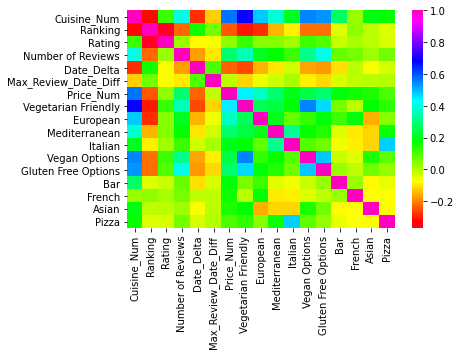

In [97]:
correlation = df[main_columns+cuisines_columns].corr()
display(correlation)
sns.heatmap(correlation, annot=False, cmap='gist_rainbow')

Ожидаемо довольно сильно коррелирует самая популярна опция cuisine style (vegetarian friendly) с количеством cuisine style в ресторане. Других значительных корреляций не вижу.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [25]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [26]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [27]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [28]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [29]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [30]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21415299999999998
